# verifying wind speed
this notebook serves to prove or disprove that the u and v calculated windspeed is the same as the surface wind speed variable in CMIP6 speed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

# cm4 wind speed 

In [3]:
##importing Surface Wind data from google cloud. Amon
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_sfw = df.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'sfcWind'& table_id == 'Amon'")

#df is define and ds is store

In [4]:
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_sfw.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_sfw = xr.open_zarr(mapper, consolidated=True)


In [5]:
wind_speed=ds_sfw.sfcWind #isolating surface windspeed array

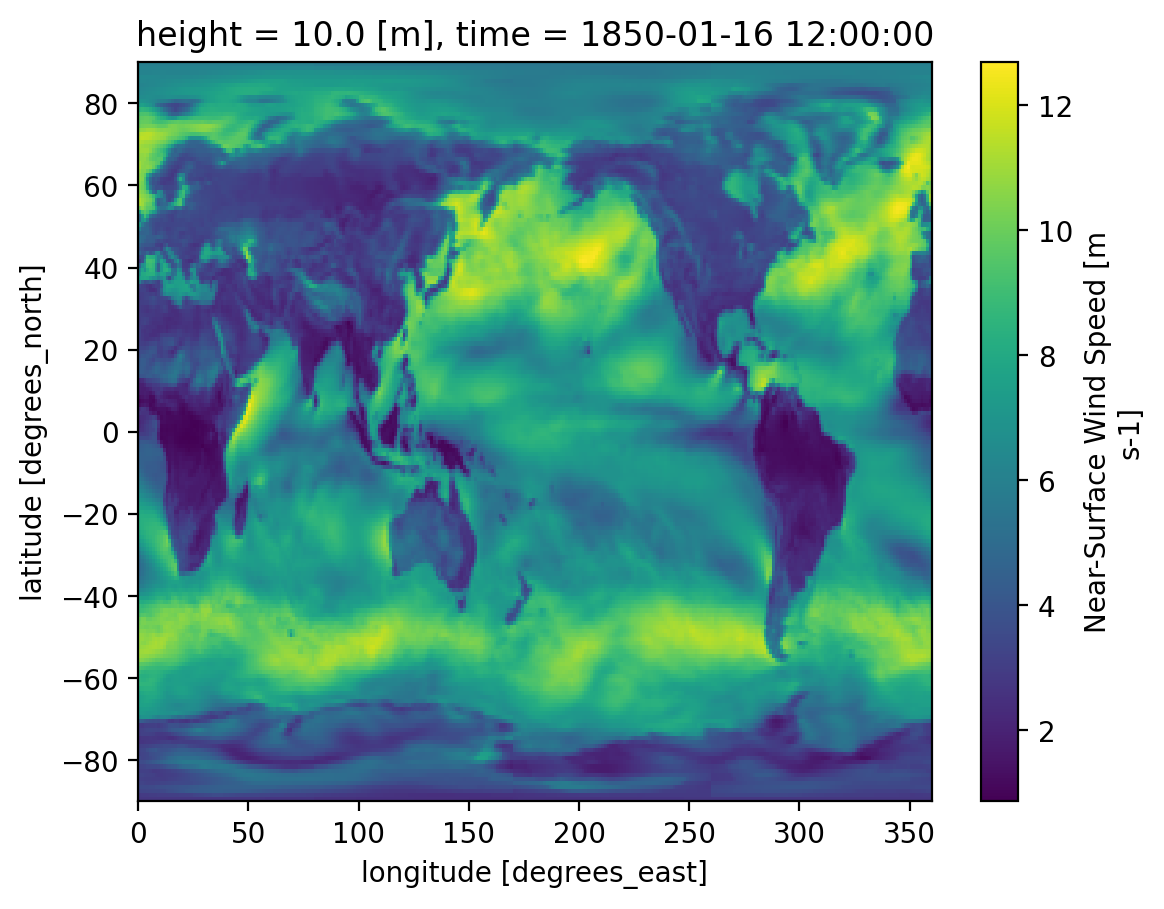

In [6]:
wind_speed.isel(time=0).plot() # verifying the height at which this wind speed is being recorded

In [7]:
wind_speed #looking at the contents of the surface wind array

<xarray.DataArray 'sfcWind' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-sfcWind, shape=(1980, 180, 288), dtype=float32, chunksize=(327, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [8]:
#slicing time for the end of the historical simulation, averaging it, and slicing for the south pole lats
overall_cm4_speed_95_2014=wind_speed.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time').sel(lat=slice(-89.5,-55))
overall_cm4_speed_95_2014

<xarray.DataArray 'sfcWind' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

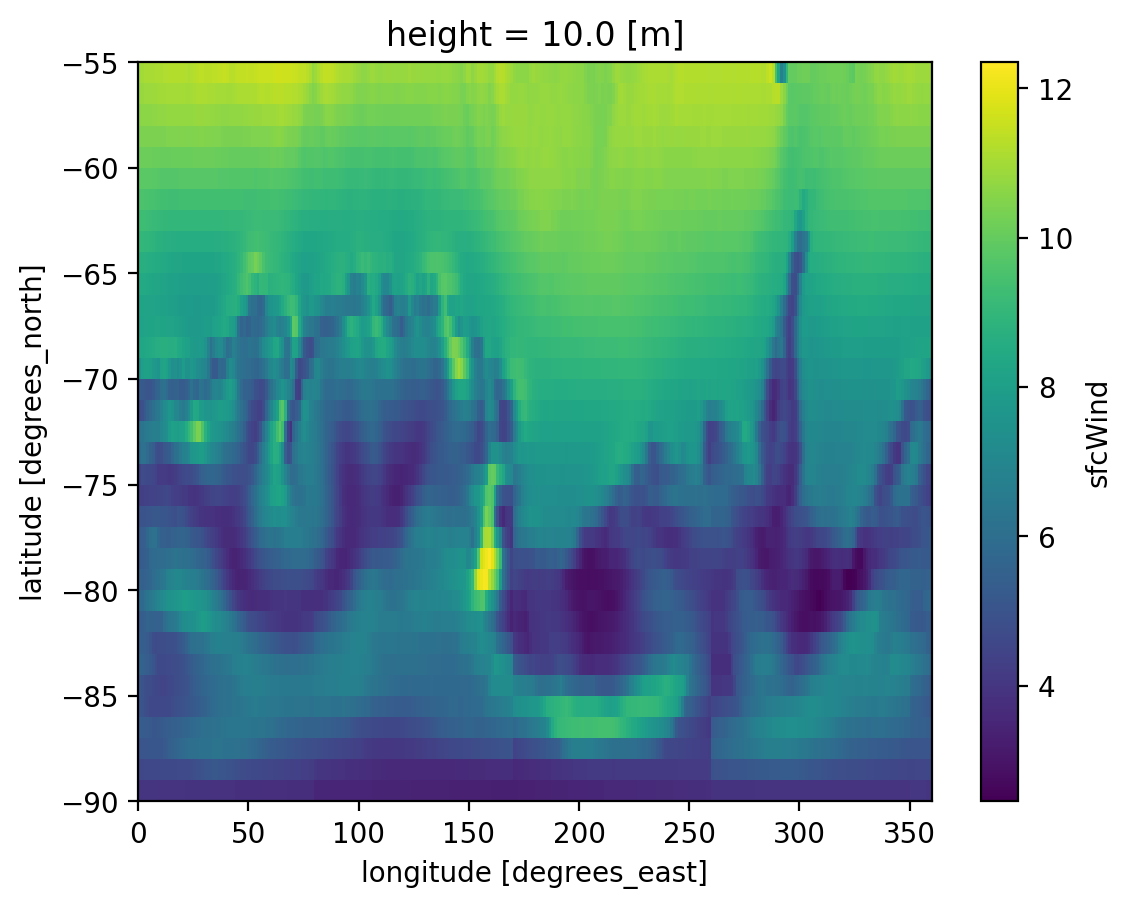

In [9]:
overall_cm4_speed_95_2014.plot() #looking at windspeed

In [10]:
#creating a seasonal wind speed by grouping
sfw_seasonal=wind_speed.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time')
sfw_seasonal

<xarray.DataArray 'sfcWind' (season: 4, lat: 35, lon: 288)>
dask.array<stack, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [11]:
sfw_cm4_summer=sfw_seasonal.sel(season='DJF')
sfw_cm4_winter=sfw_seasonal.sel(season='JJA')
sfw_cm4_spring=sfw_seasonal.sel(season='SON')
sfw_cm4_fall=sfw_seasonal.sel(season='MAM')

In [12]:
sfw_cm4_summer

<xarray.DataArray 'sfcWind' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    season   <U3 'DJF'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Near-Surface Wind Speed
    original_name:  sfcWind
    standard_name:  wind_speed
    units:          m s-1

In [13]:
#applying spatial masks and averaging lat and lon out to get one value for the bar plot
plateau_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
ross_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
lowwest_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
loweast_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
filchner_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
peninsula_wind_total_CM4=(overall_cm4_speed_95_2014*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [14]:
#printing the wind speed of each region
plat_value_CM4_total=print(plateau_wind_total_CM4.values)
ross_value_CM4_total= print(ross_wind_total_CM4.values)
west_value_CM4_total=print(lowwest_wind_total_CM4.values)
east_value_CM4_total=print(loweast_wind_total_CM4.values)
filch_value_CM4_total=print(filchner_wind_total_CM4.values)
pen_value_CM4_total=print(peninsula_wind_total_CM4.values)

5.1637974
4.372187
6.002784
7.064384
3.834539
6.6700025


# cm4 u and v component

In [15]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_historical = df_uas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)

Uas_historical = ds_uas_historical_use.uas #extracting uas variable
Uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(305, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

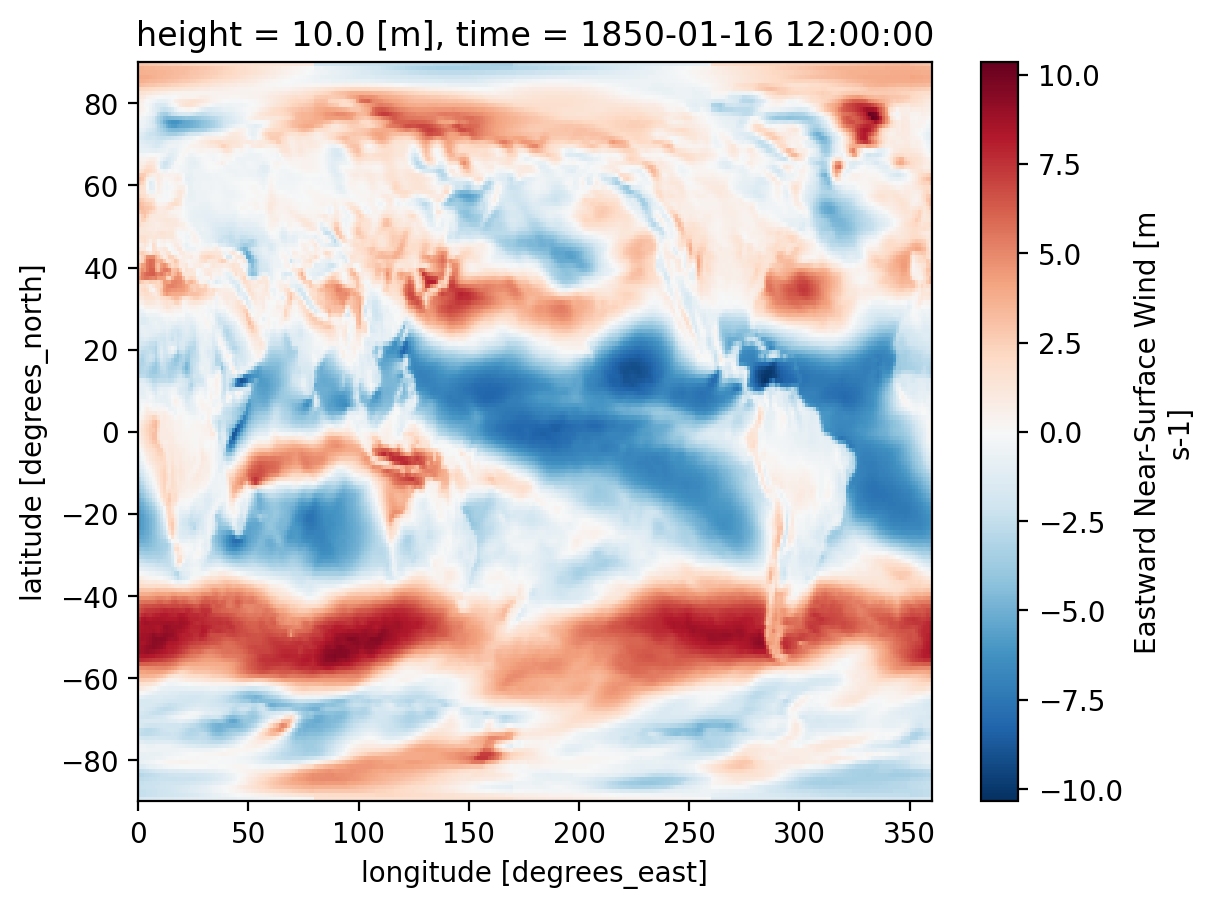

In [16]:
Uas_historical.isel(time=0).plot()

In [17]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)

historical_vas=ds_vas_historical.vas
historical_vas

<xarray.DataArray 'vas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1980, 180, 288), dtype=float32, chunksize=(298, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

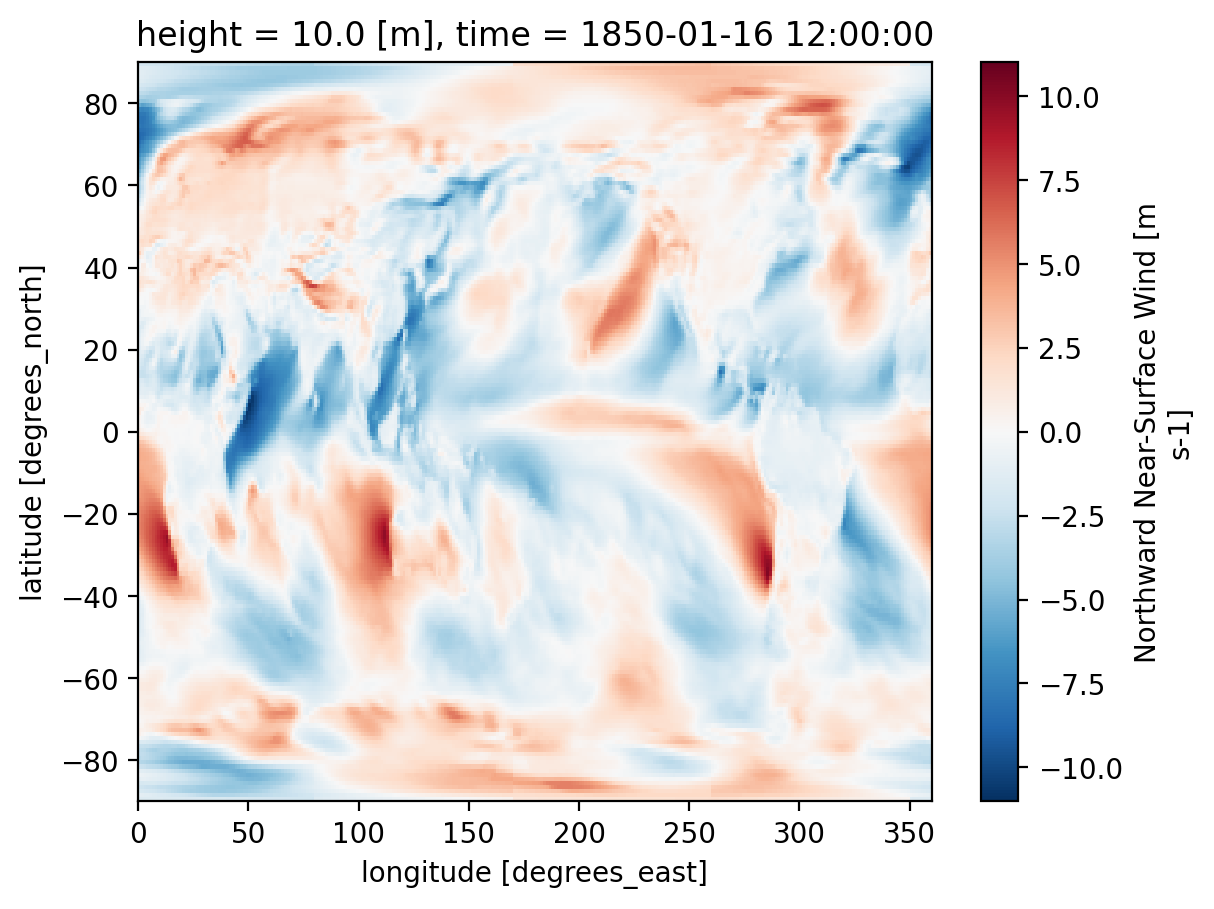

In [18]:
historical_vas.isel(time=0).plot() #verifying the wind speed was measured at 10 meters

In [19]:
#slicing into seasons and averaging it, also selecting south pole region 
vas_his_seasonal=historical_vas.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
vas_his_seasonal
uas_his_seasonal=Uas_historical.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
uas_his_seasonal

<xarray.DataArray 'uas' (season: 4, lat: 35, lon: 288)>
dask.array<getitem, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [20]:
#extracting just uas and vas data and slicing south pole lat and time 
Uas_historical1 = ds_uas_historical_use.uas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16'))
historical_vas1=ds_vas_historical.vas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16'))
Uas_historical1

<xarray.DataArray 'uas' (time: 240, lat: 35, lon: 288)>
dask.array<getitem, shape=(240, 35, 288), dtype=float32, chunksize=(150, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [21]:
# merging u and v component into one dataset
his_mergewinds = xr.merge([Uas_historical1,historical_vas1]) # merge uas and vas components 
xmerge = his_mergewinds.lon #extracting the lon component from the mergewinds array
ymerge = his_mergewinds.lat
umerge = his_mergewinds.uas 
vmerge = his_mergewinds.vas
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector formula

## time average
timeaveragemerge = his_mergewinds.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')
timeaveragemerge

#averaging time of speedmerge to use as overall wind speed
speedslice = speedmerge.mean(dim='time')

## UAS seasonal dataset
uas_his_seasonal

## VAS seasonal plot
vas_his_seasonal

## merging the UAS seasonal and Vas seasonal to get merge seasonal
his_seasonalmerge = xr.merge([uas_his_seasonal,vas_his_seasonal])
his_seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [22]:
speedslice

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [23]:
speedmerge

<xarray.DataArray (time: 240, lat: 35, lon: 288)>
dask.array<sqrt, shape=(240, 35, 288), dtype=float32, chunksize=(150, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00

In [24]:
his_mergewinds

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, time: 240)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    uas      (time, lat, lon) float32 dask.array<chunksize=(90, 35, 288), meta=np.ndarray>
    vas      (time, lat, lon) float32 dask.array<chunksize=(48, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [25]:
## calculating the seasonal wind speed
seasonal_speedmerge = np.sqrt(np.square(his_seasonalmerge.uas) + np.square(his_seasonalmerge.vas))

## slicing the summer speed
Summer_szn_speed = seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= his_seasonalmerge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= his_seasonalmerge.sel(season='JJA')

## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= his_seasonalmerge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= his_seasonalmerge.sel(season='SON')

In [26]:
#applying spatial masks
u_plateau_wind_total_CM4=(speedslice*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
u_ross_wind_total_CM4=(speedslice*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
u_lowwest_wind_total_CM4=(speedslice*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
u_loweast_wind_total_CM4=(speedslice*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
u_filchner_wind_total_CM4=(speedslice*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
u_peninsula_wind_total_CM4=(speedslice*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

In [27]:
test_plat_value_CM4_total=print(u_plateau_wind_total_CM4.values)
test_ross_value_CM4_total= print(u_ross_wind_total_CM4.values)
test_west_value_CM4_total=print(u_lowwest_wind_total_CM4.values)
test_east_value_CM4_total=print(u_loweast_wind_total_CM4.values)
test_filch_value_CM4_total=print(u_filchner_wind_total_CM4.values)
test_pen_value_CM4_total=print(u_peninsula_wind_total_CM4.values)

4.5343966
3.1111586
5.426562
6.6718707
2.4380293
3.5936568


# the downloaded wind speed has higher values than the calculated wind speed from the u and v components. they are closer to the era5 data though

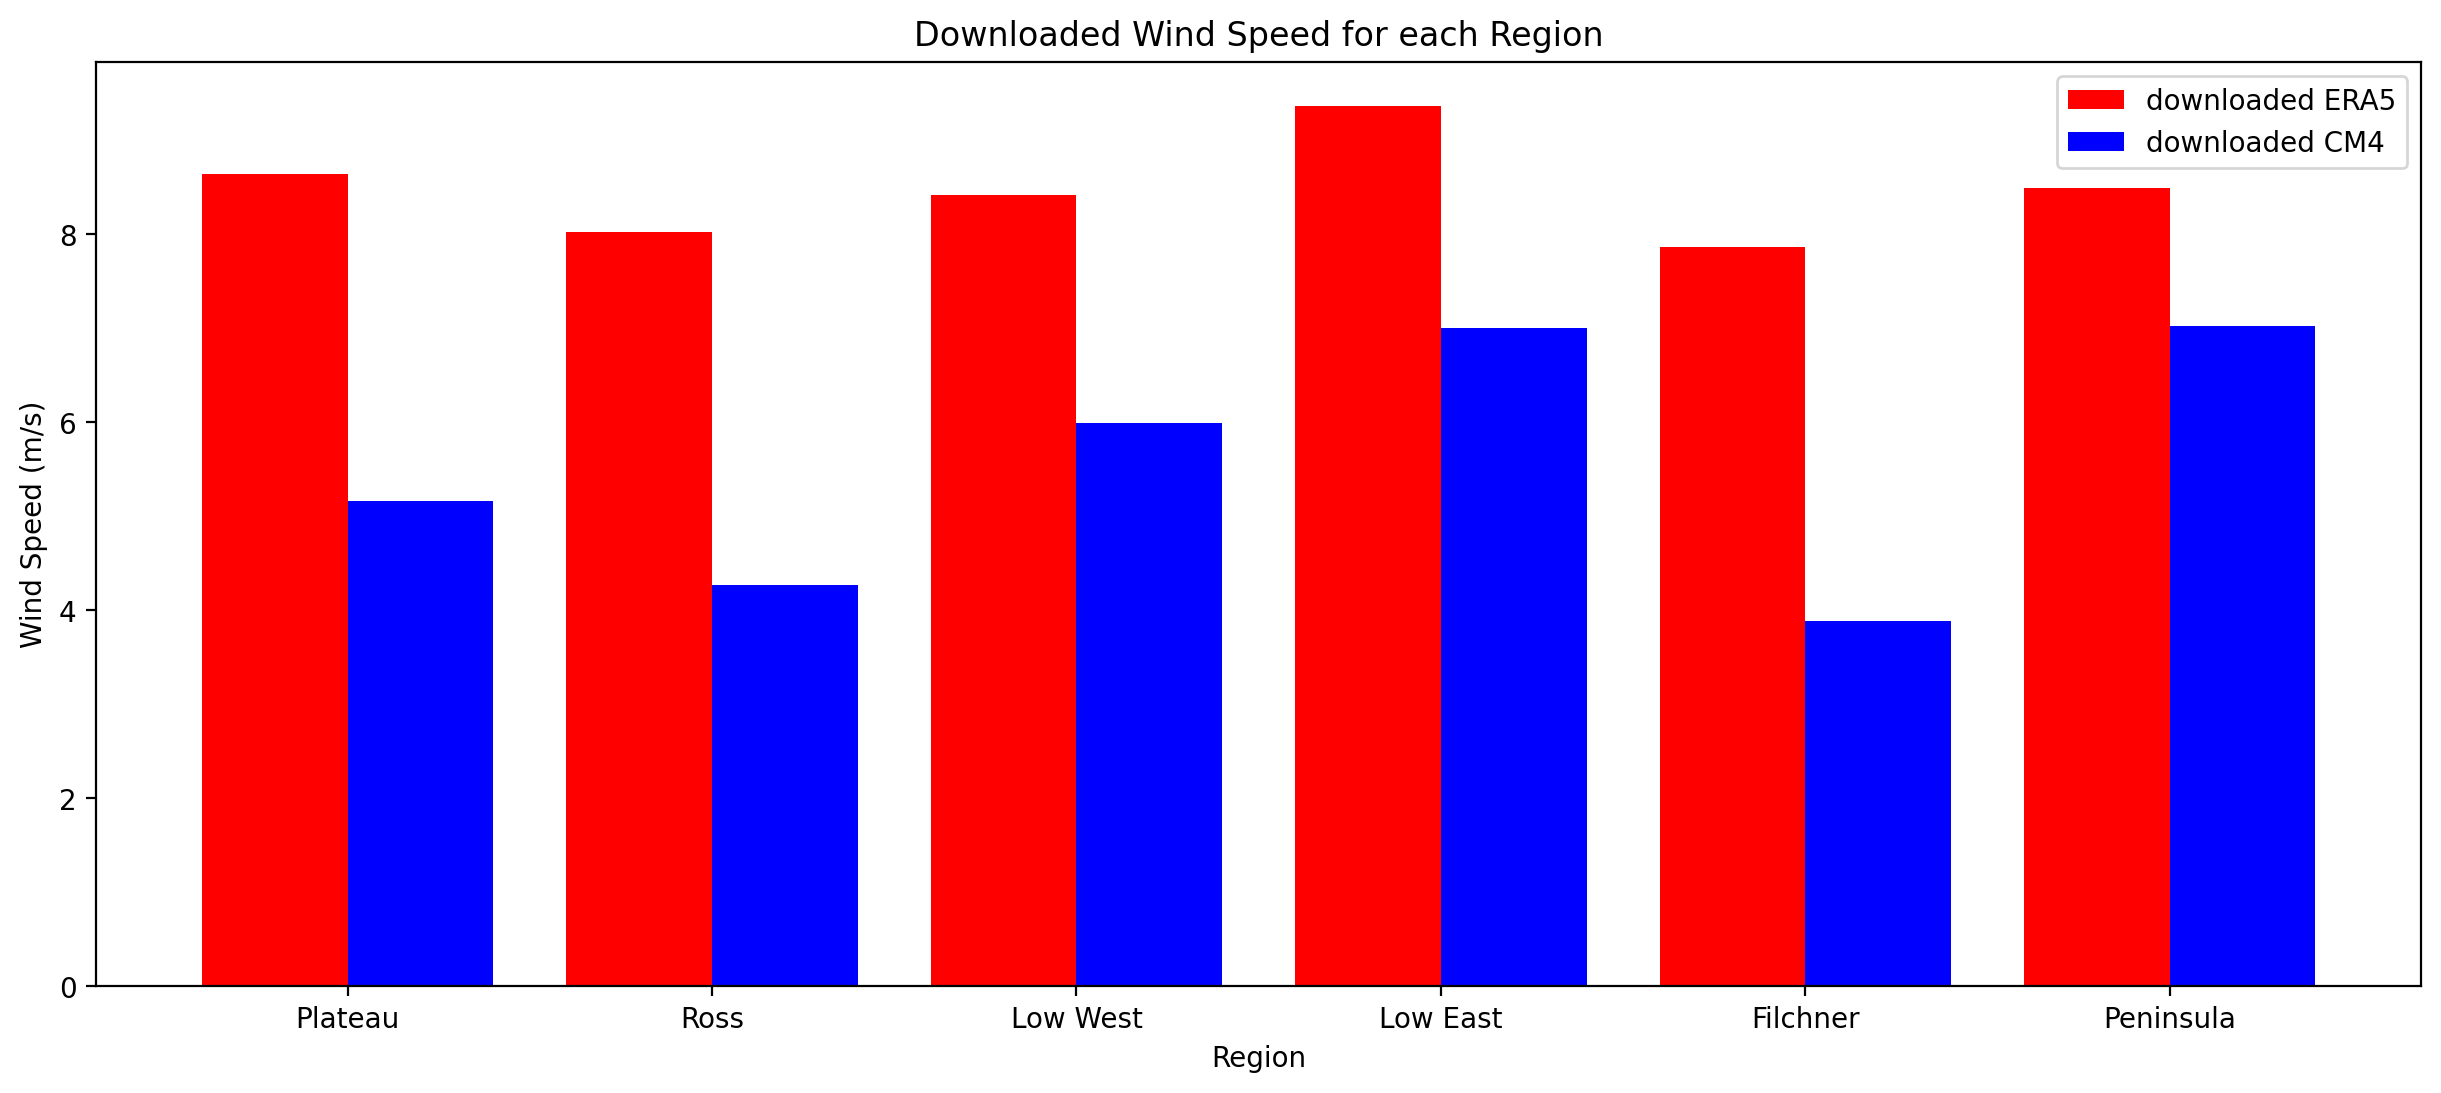

In [28]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [5.1637974,
4.2680964,
5.9914885,
6.9997835,
3.887733,
7.0219145]
ERA5 = [8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]
# the era5 numbers are from my historical notebook. i just copied and pasted them over to cut down on loading time.  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ERA5, 0.4, label = 'downloaded ERA5', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'downloaded CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Downloaded Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

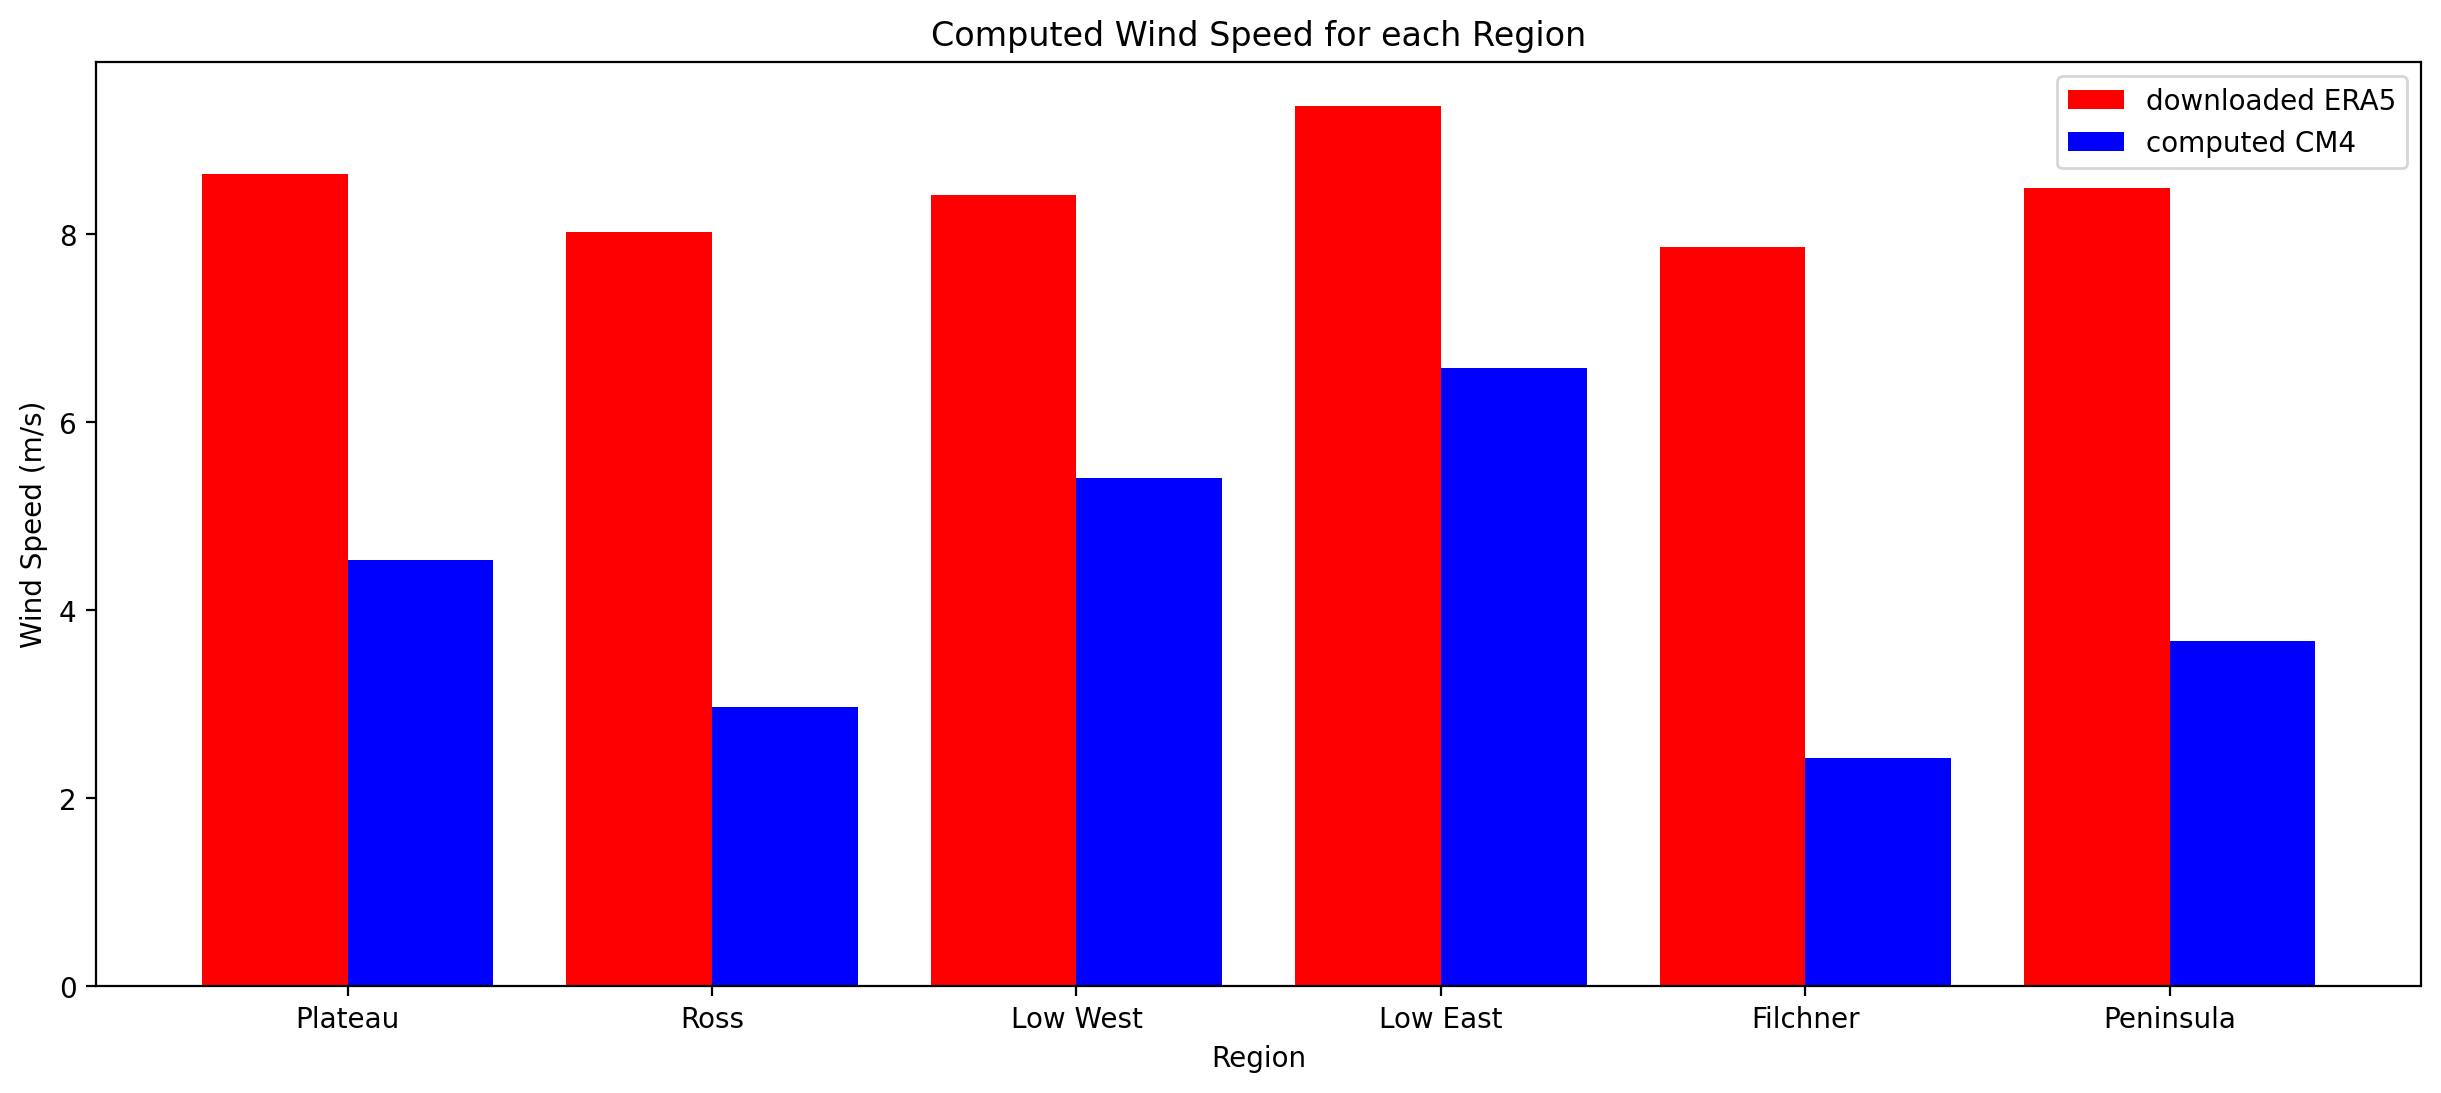

In [29]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [4.5343966,
2.9753473,
5.406358,
6.578784,
2.431819,
3.6770608]
ERA5 = [8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]
# the era5 numbers are from my historical notebook. i just copied and pasted them over to cut down on loading time. 
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ERA5, 0.4, label = 'downloaded ERA5', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'computed CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Computed Wind Speed for each Region") 
plt.legend() 
#plt.ylim(220,240)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# esm4 wind speed variable 

In [30]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'sfcWind' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

In [31]:
esm4_wind_speed=esm4_uas.sfcWind

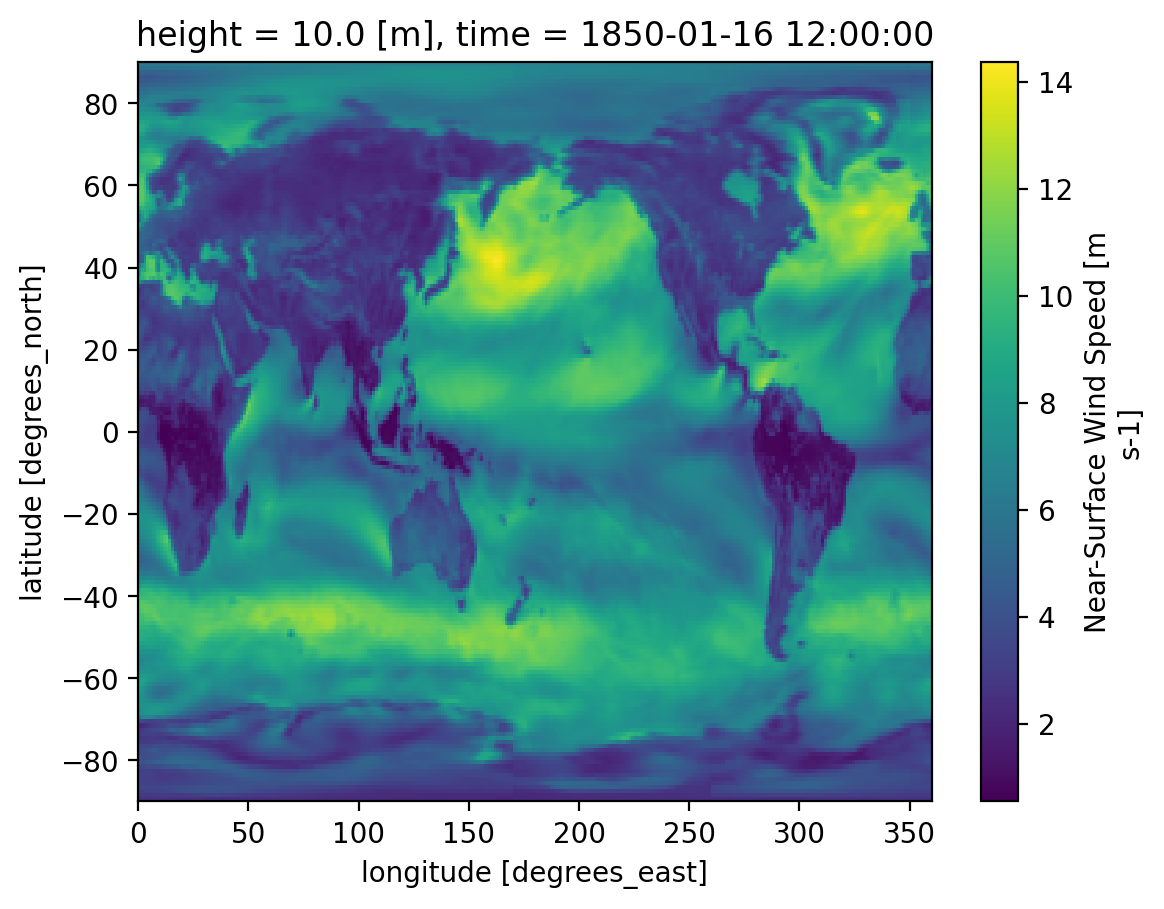

In [32]:
esm4_wind_speed.isel(time=0).plot()

In [33]:
#slicing time, averaging it, and slicing for the south pole lats
overall_esm4_speed_95_2014=esm4_wind_speed.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time').sel(lat=slice(-89.5,-55))
overall_esm4_speed_95_2014

<xarray.DataArray 'sfcWind' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

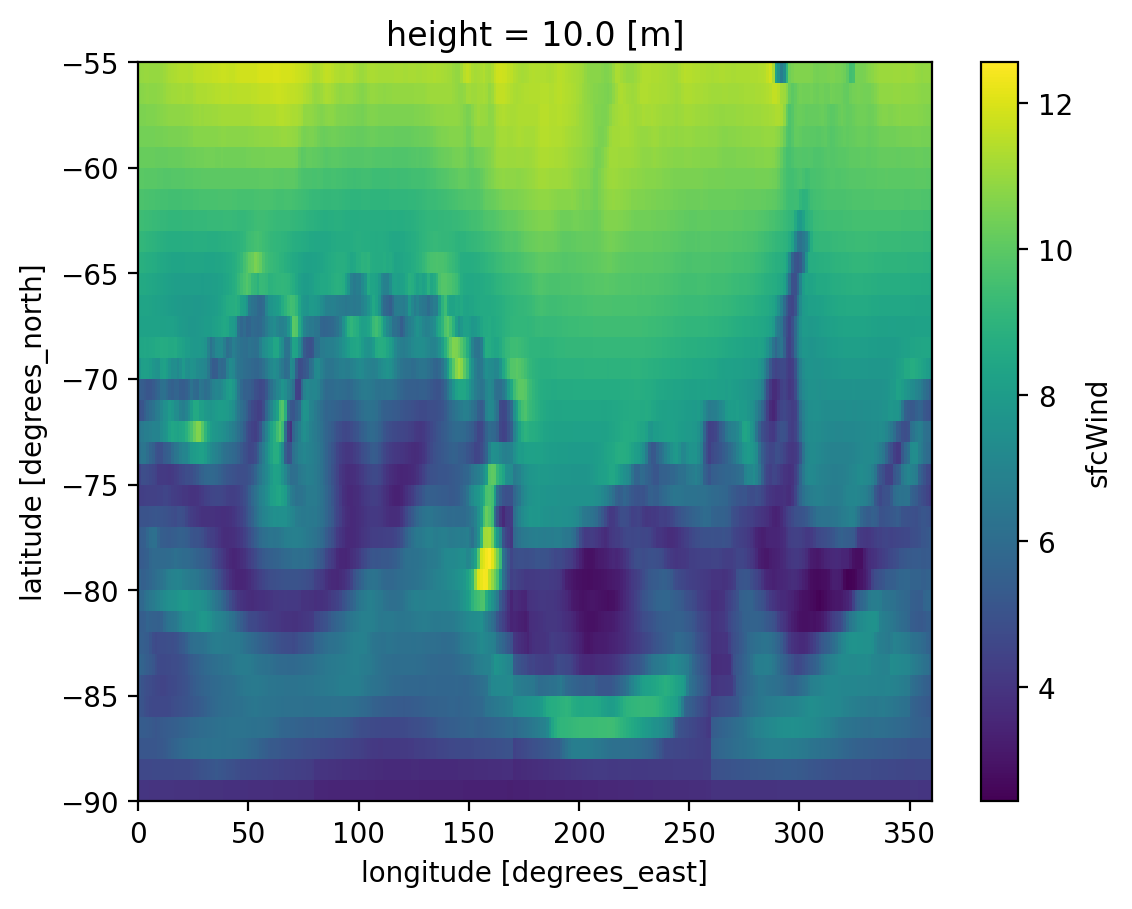

In [34]:
overall_esm4_speed_95_2014.plot()

In [35]:
plateau_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
ross_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
lowwest_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
loweast_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
filchner_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
peninsula_wind_total_ESM4=(overall_esm4_speed_95_2014*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

In [36]:
plat_value_ESM4_total=print(plateau_wind_total_ESM4.values)
ross_value_ESM4_total= print(ross_wind_total_ESM4.values)
west_value_ESM4_total=print(lowwest_wind_total_ESM4.values)
east_value_ESM4_total=print(loweast_wind_total_ESM4.values)
filch_value_ESM4_total=print(filchner_wind_total_ESM4.values)
pen_value_ESM4_total=print(peninsula_wind_total_ESM4.values)

5.1919904
4.3590093
6.077986
7.196596
3.863573
6.661836


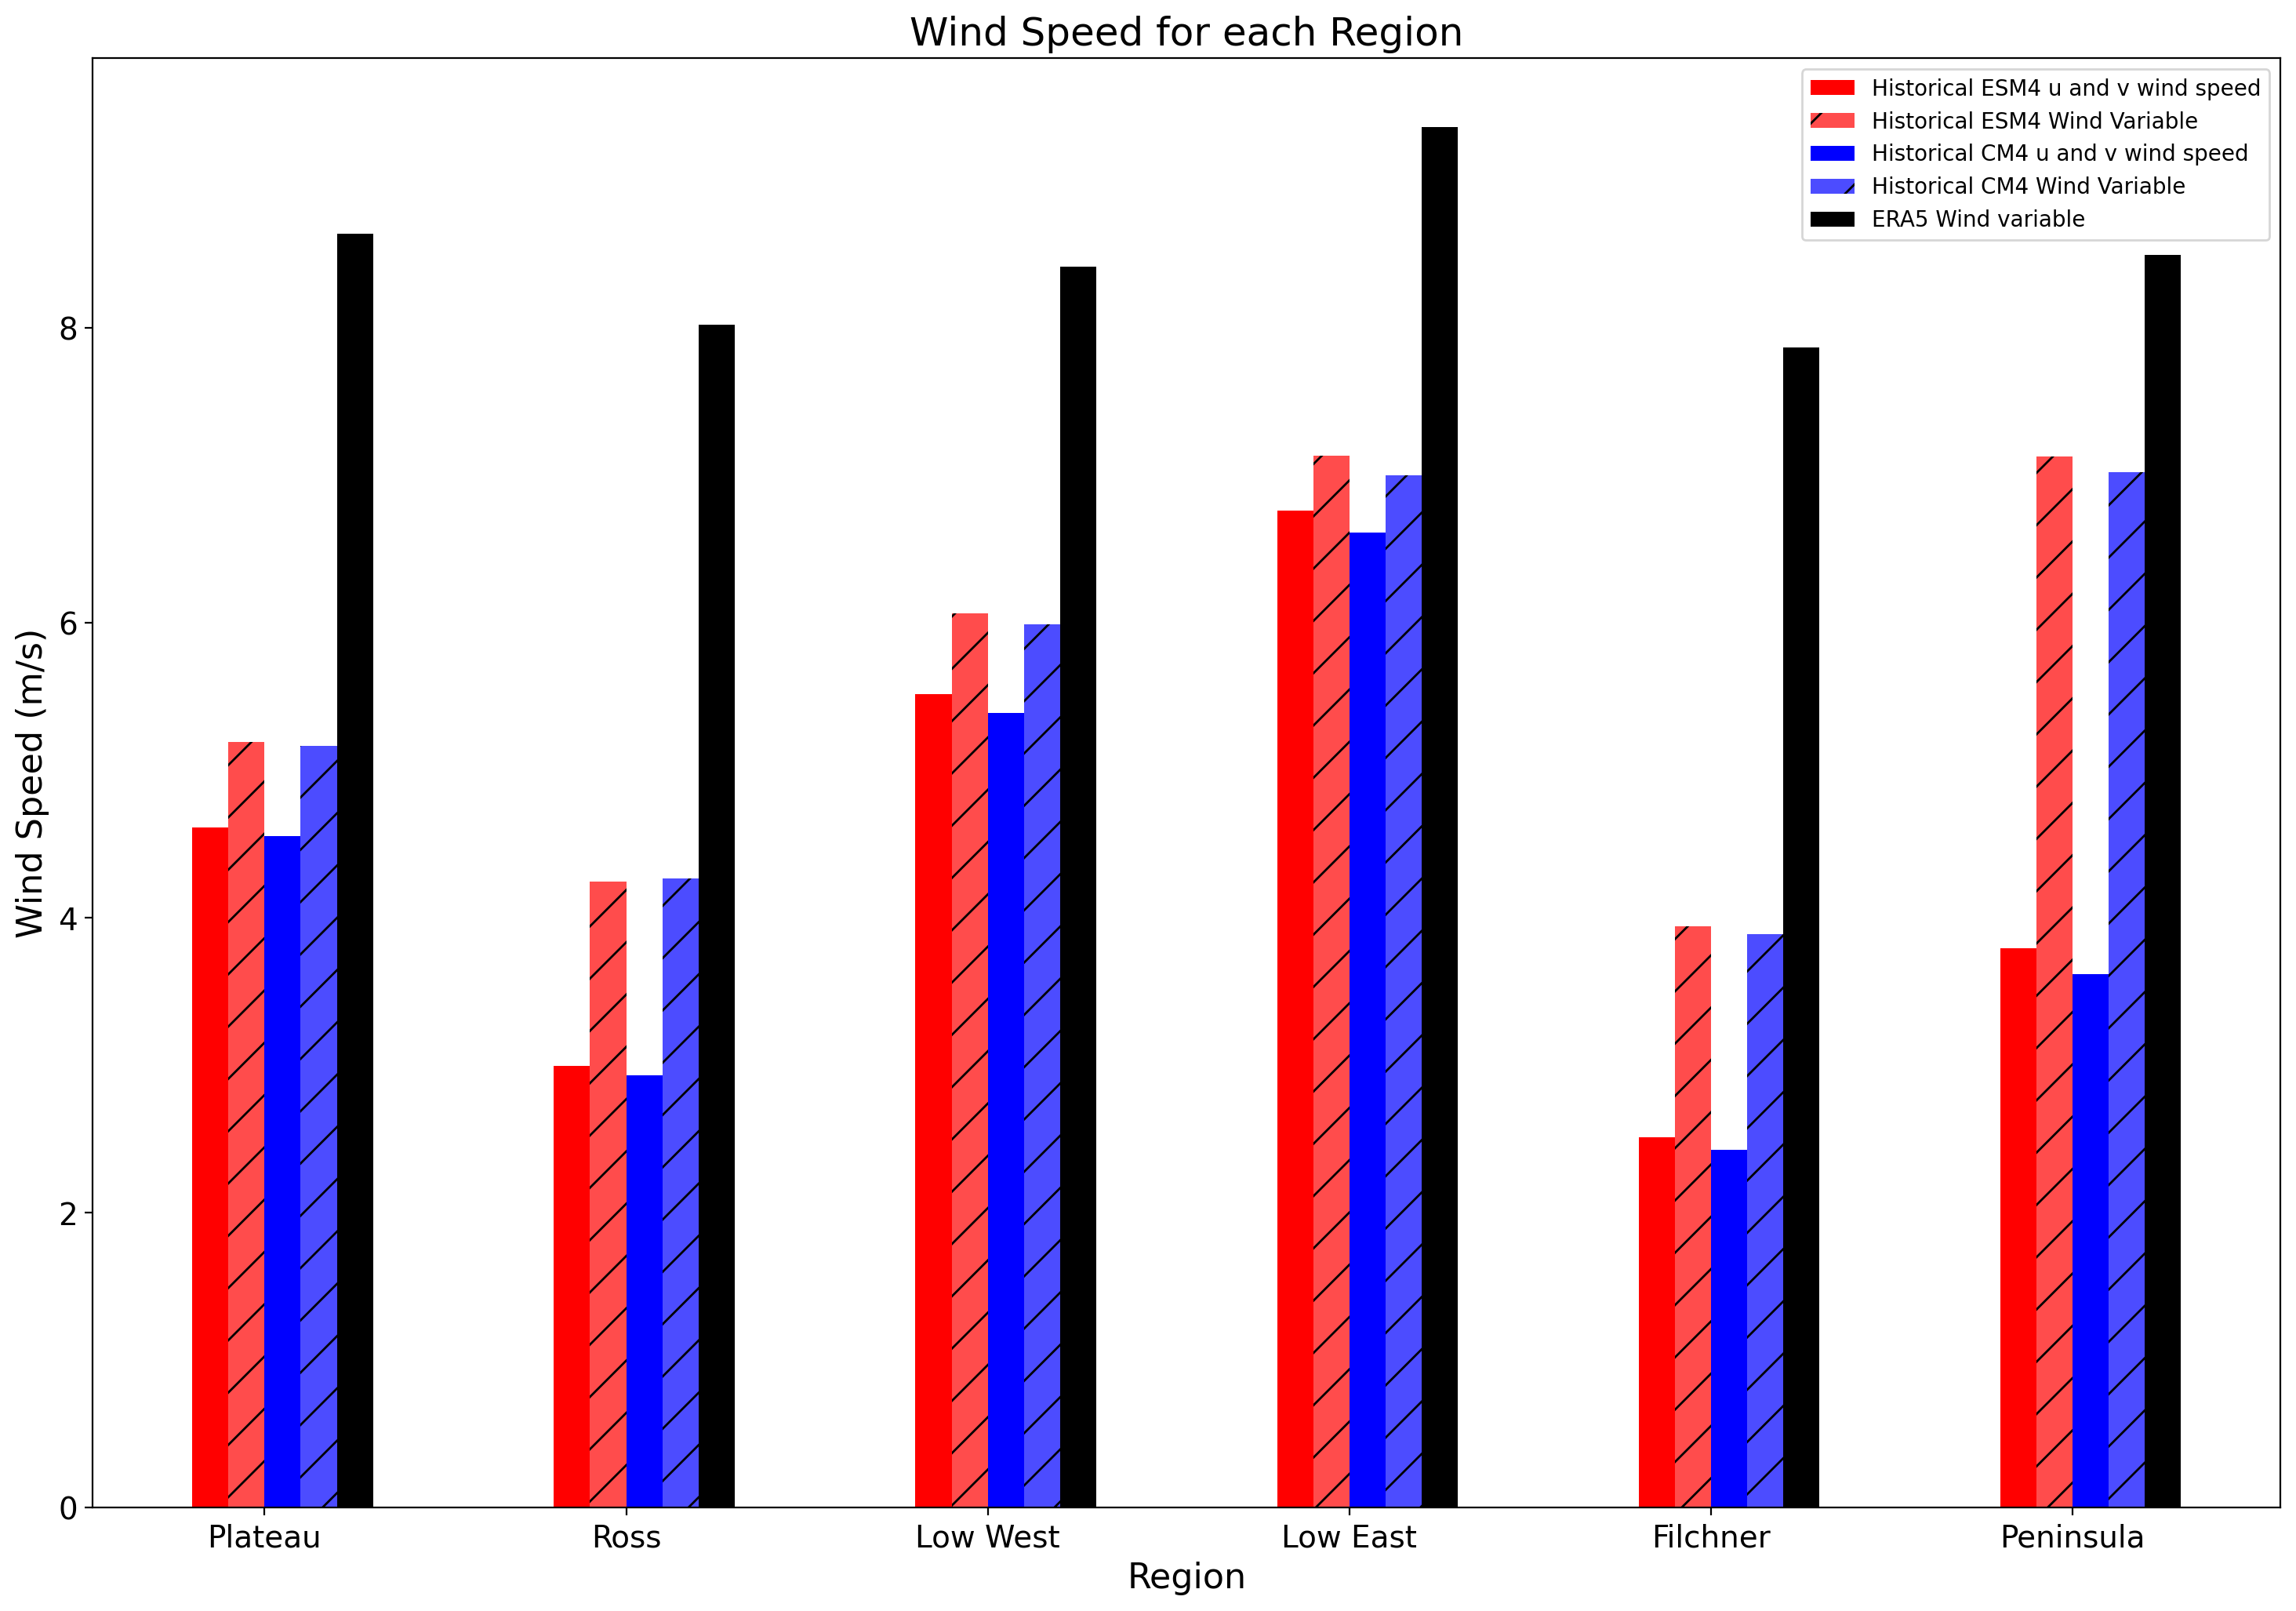

In [37]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (18,12))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
u_v_CM4 = [4.556596,
2.9305322,
5.388403,
6.6122456,
2.4263186,
3.619592]
u_v_ESM4 = [4.610894,
2.9960504,
5.5168953,
6.7622037,
2.511684,
3.7957954]
# the u n v esm4 numbers are from my historical notebook. i just copied and pasted them over

ERA=[8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]
# the era5 numbers are from my historical notebook. i just copied and pasted them over to cut down on loading time.

CM4_wind_speed_variable= [5.1637974,
4.2680964,
5.9914885,
6.9997835,
3.887733,
7.0219145]
ESM4_wind_speed_variable=[5.1919904,
4.246693,
6.0626507,
7.1325707,
3.9445462,
7.1307807]                      
  
X_axis = np.arange(len(X)) *2
  
bar_width = 0.2

plt.bar(X_axis - 1.5 * bar_width, u_v_ESM4, bar_width, label='Historical ESM4 u and v wind speed', color='r')
plt.bar(X_axis - 0.5 * bar_width, ESM4_wind_speed_variable, bar_width, label='Historical ESM4 Wind Variable', color='r', hatch="/",alpha=0.7)
plt.bar(X_axis + 0.5 * bar_width, u_v_CM4, bar_width, label='Historical CM4 u and v wind speed', color='blue')
plt.bar(X_axis + 1.5 * bar_width, CM4_wind_speed_variable, bar_width, label='Historical CM4 Wind Variable', color='blue', hatch="/",alpha=0.7)
plt.bar(X_axis + 2.5 * bar_width, ERA, bar_width, label='ERA5 Wind variable', color='k')


plt.xticks(X_axis, X, fontsize=14)  # Increase font size of x-axis ticks
plt.yticks(fontsize=14)  # Increase font size of y-axis ticks
plt.xlabel("Region", fontsize=16)  # Increase font size of x-axis label
plt.ylabel("Wind Speed (m/s)", fontsize=16)  # Increase font size of y-axis label
plt.title("Wind Speed for each Region", fontsize=18)  # Increase font size of the title
plt.legend() 

plt.show()